# Predicting London Bike Share Rides

The target variable, "cnt", is the total number of bike share rides initiated in a given hour in London. 
The dataset was compiled by Hristo Mavrodiev using the TfL Open Data: https://cycling.data.tfl.gov.uk/
The dataset is located here: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

## Preprocessing and Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import linear_model

In [137]:
df = pd.read_csv("LondonBikeshare.csv")

In [138]:
df.head()

,timestamp,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season
0,1/4/15 0:00,182,3.0,2.0,93.0,6.0,3,0,1,3
1,1/4/15 1:00,138,3.0,2.5,93.0,5.0,1,0,1,3
2,1/4/15 2:00,134,2.5,2.5,96.5,0.0,1,0,1,3
3,1/4/15 3:00,72,2.0,2.0,100.0,0.0,1,0,1,3
4,1/4/15 4:00,47,2.0,0.0,93.0,6.5,1,0,1,3


In [139]:
# Extract hour from timestamp
df['hour'] = df['timestamp'].str[-5:-3]

In [140]:
df['hour'] = df['hour'].str.strip()

In [141]:
df['hour'] = df['hour'].astype(int)

In [142]:
df = df.drop('timestamp',1)

In [143]:
df.head()

,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season,hour
0,182,3.0,2.0,93.0,6.0,3,0,1,3,0
1,138,3.0,2.5,93.0,5.0,1,0,1,3,1
2,134,2.5,2.5,96.5,0.0,1,0,1,3,2
3,72,2.0,2.0,100.0,0.0,1,0,1,3,3
4,47,2.0,0.0,93.0,6.5,1,0,1,3,4


In [144]:
# Count null values in each column
df.isnull().sum()

cnt             0
temp            0
tempfeel        0
humidity        0
windspeed       0
weather_code    0
is_holiday      0
is_weekend      0
season          0
hour            0
dtype: int64

In [145]:
# summary statistics
round(df.describe(),3)

,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season,hour
count,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000
mean,1143.102,12.468,11.521,72.325,15.913,2.723,0.022,0.285,1.492,11.513
std,1085.108,5.572,6.615,14.313,7.895,2.341,0.147,0.452,1.119,6.916
min,0.000,-1.500,-6.000,20.500,0.000,1.000,0.000,0.000,0.000,0.000
25%,257.000,8.000,6.000,63.000,10.000,1.000,0.000,0.000,0.000,6.000
50%,844.000,12.500,12.500,74.500,15.000,2.000,0.000,0.000,1.000,12.000
75%,1671.750,16.000,16.000,83.000,20.500,3.000,0.000,1.000,2.000,18.000
max,7860.000,34.000,34.000,100.000,56.500,26.000,1.000,1.000,3.000,23.000


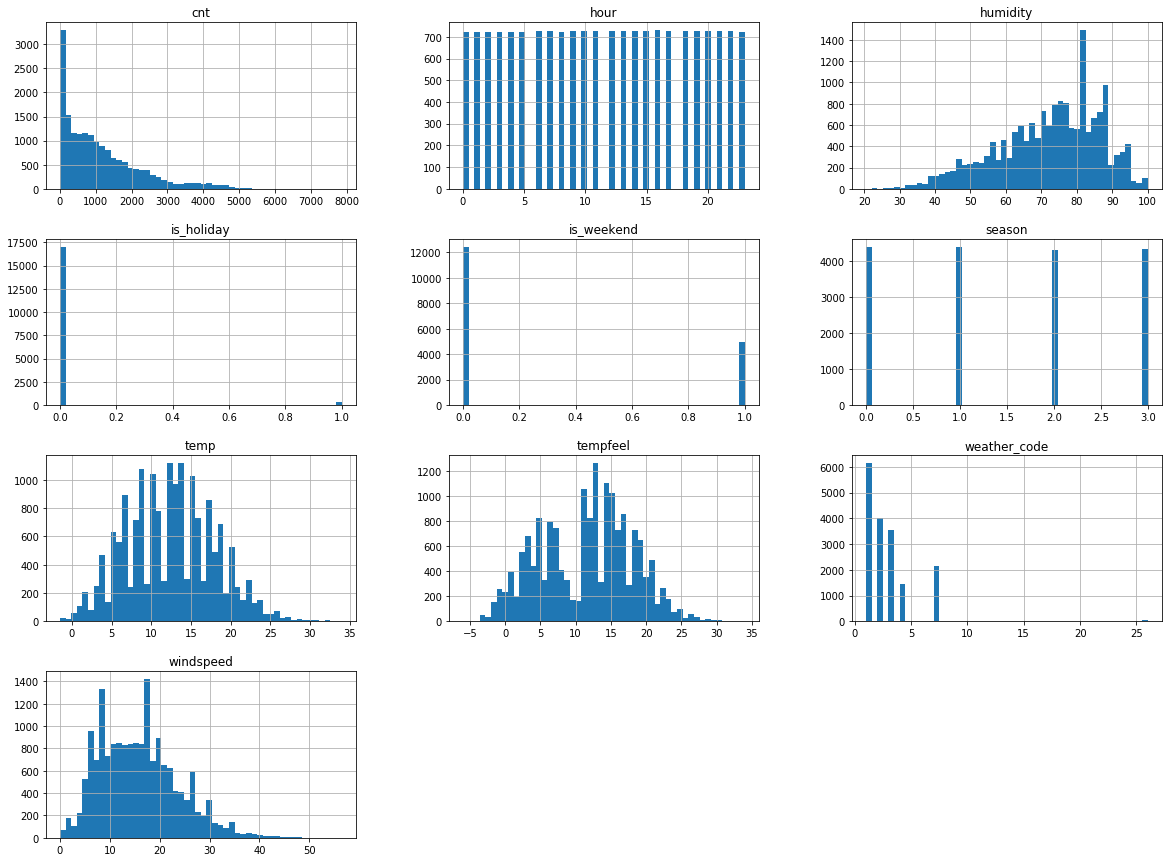

In [147]:
#histograms to get a first glimpse of the data
df.hist(bins=50, figsize=(20,15))
plt.show()

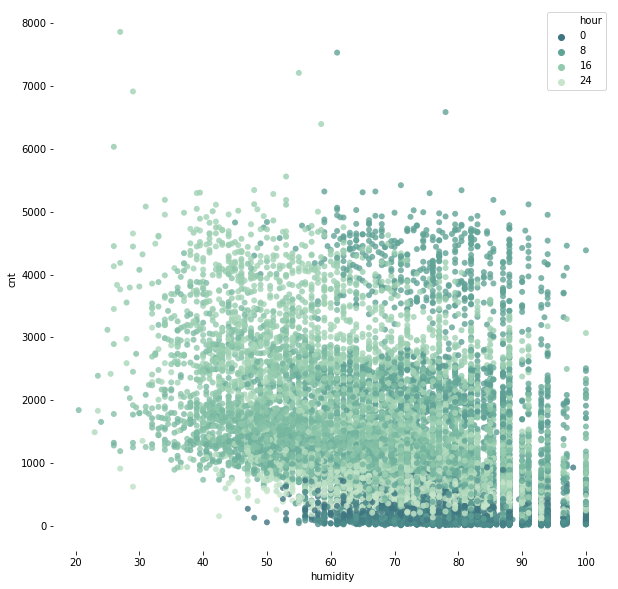

In [150]:
#Scatter plot of count vs humidity, colored by hour
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="humidity", y="cnt",
               hue="hour",
               palette="ch:r=-0.4, d=0.4_r",
               alpha=0.8, linewidth=0,
               data=df, ax=ax)

In [153]:
#Correlation of Count and other variables
corr_matrix = df.corr()
corr_matrix["cnt"].sort_values(ascending=False).head(15)

cnt             1.000000
temp            0.388798
tempfeel        0.369035
hour            0.324423
windspeed       0.116295
is_holiday     -0.051698
is_weekend     -0.096499
season         -0.116180
weather_code   -0.166633
humidity       -0.462901
Name: cnt, dtype: float64

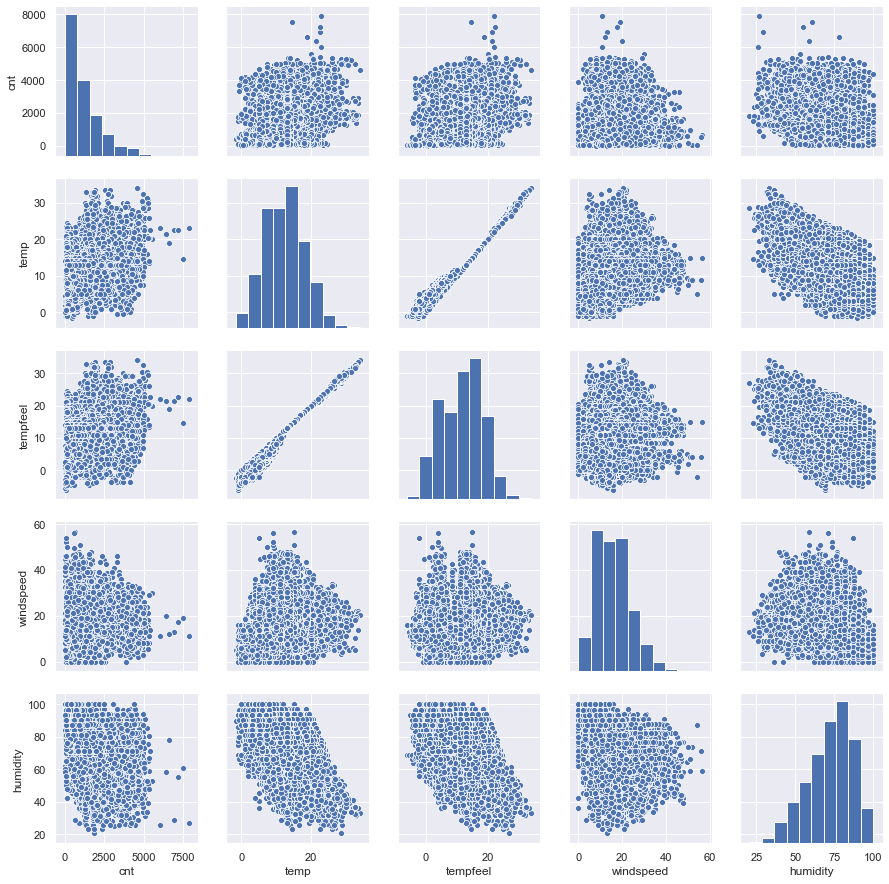

In [159]:
#Pair plots
sns.set()
attributes = ["cnt", "temp", "tempfeel", "windspeed", "humidity"]
sns.pairplot(df[attributes], height=2.5)
plt.show()

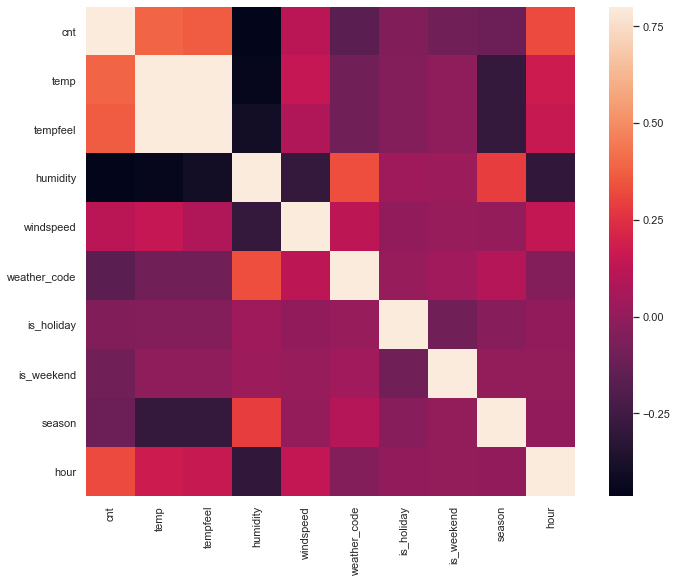

In [160]:
#Heat Map
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=.8, square=True)

## Prepare Data for Modeling

In [167]:
# Reduce dataset to variables with highest correlation with Count
# dropped tempfeel because of its close relationship to temp, 
# and because temp has higher correlation with Count

X_all = df[["temp", "windspeed", "hour"]]
y_all = df[["cnt"]]

In [174]:
# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_all)
X_scaled = scaler.fit_transform(X_all)

In [176]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)

## Gradient Boosted Trees

In [181]:
# Model Count using gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=240)
gbrt.fit(X_train, y_train)

/Users/dbalas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=240,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [182]:
from sklearn import metrics

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))
y_pred = gbrt.predict(X_test)
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy on training set: 0.703
Accuracy on test set: 0.709
Root Mean Squared Error: 590.373531011044


In [186]:
#Best ensemble from 120 trees:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5000)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)


gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

/Users/dbalas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dbalas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1098,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [187]:
print("Accuracy on training set: {:.3f}".format(gbrt_best.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_best.score(X_test, y_test)))

y_pred = gbrt_best.predict(X_test)
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy on training set: 0.714
Accuracy on test set: 0.711
Root Mean Squared Error: 588.1062140412214


In [192]:
#Best ensemble from 10000 trees:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=10000)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)


gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

/Users/dbalas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dbalas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1098,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [193]:
print("Accuracy on training set: {:.3f}".format(gbrt_best.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_best.score(X_test, y_test)))

y_pred = gbrt_best.predict(X_test)
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy on training set: 0.714
Accuracy on test set: 0.711
Root Mean Squared Error: 588.1062140412214


In [194]:
from xgboost.sklearn import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'